## 1. Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode (connected=True)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.io as pio
pio.renderers.default='notebook'
from IPython.display import Image

## 2. Loading Dataset

In [4]:
df=pd.read_csv('Space_Mission_Dataset.csv')

In [5]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success


In [6]:
df.shape

(4324, 9)

In [7]:
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
Company Name      object
Location          object
Datum             object
Detail            object
Status Rocket     object
 Rocket           object
Status Mission    object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
Unnamed: 0        4324 non-null int64
Unnamed: 0.1      4324 non-null int64
Company Name      4324 non-null object
Location          4324 non-null object
Datum             4324 non-null object
Detail            4324 non-null object
Status Rocket     4324 non-null object
 Rocket           964 non-null object
Status Mission    4324 non-null object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


## 3. Data Cleaning

First we remove unnecessary columns.

In [9]:
df.drop(['Unnamed: 0','Unnamed: 0.1','Detail'], axis=1,inplace=True)

Next we create a dataframe that shows the percentage of null values in each column of df.

In [10]:
100*df.isnull().sum()/df.shape[0]

Company Name       0.000000
Location           0.000000
Datum              0.000000
Status Rocket      0.000000
 Rocket           77.705828
Status Mission     0.000000
dtype: float64

The Rocket column contains 77% null values, so we drop the entire column.

In [11]:
df.drop([' Rocket'], axis=1,inplace=True)

## 4. Feature Engineering

We rename some of the columns.

In [12]:
df.columns=df.columns.str.lower().str.replace(' ','_')

Now we change the format of date and add month column to df.

In [13]:
df['datum']=pd.to_datetime(df['datum'])

In [14]:
type(df['datum'].iloc[0])

datetime.datetime

In [15]:
df['year']=df['datum'].apply(lambda x: x.year)

In [16]:
df.drop(['datum'], axis=1,inplace=True)

Now we extract the name of countries from the location column and add the country column to the dataframe.

In [17]:
df['country']=df['location'].apply(lambda x: x.split(',')[-1])

In [18]:
df.head(2)

,company_name,location,status_rocket,status_mission,year,country
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",StatusActive,Success,2020,USA
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",StatusActive,Success,2020,China


## 5. Exploratory Data Analysis

We want to find the total number of missions conducted by each company.

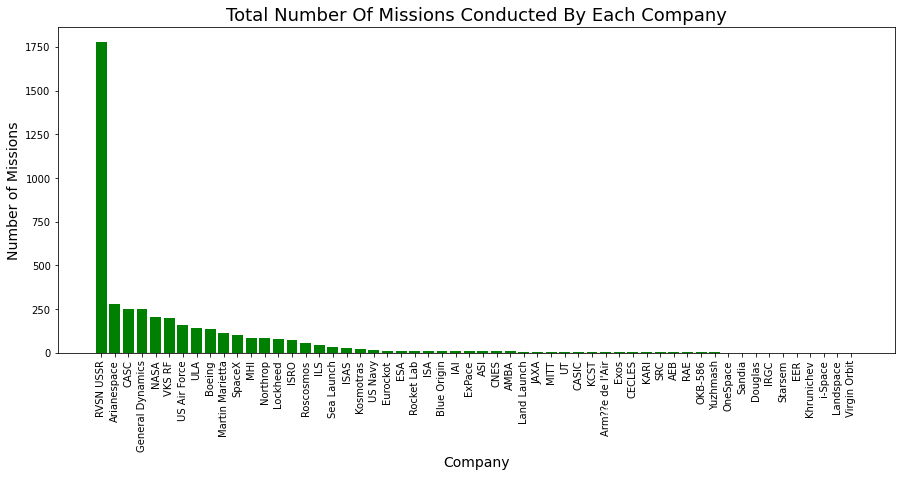

In [90]:
plt.figure(figsize=(15,6))
plt.bar(x=list(df['company_name'].value_counts().index), height=list(df['company_name'].value_counts()),color='g')
plt.xticks(rotation=90)
plt.xlabel('Company',fontsize=14)
plt.ylabel('Number of Missions',fontsize=14)
plt.title('Total Number Of Missions Conducted By Each Company',fontsize=18)
plt.show()

We visualize the status of missions conducted by each company.

In [71]:
new1=[]
for x in df['company_name'].unique():
    df1=df[df['company_name']==x]
    new1.append(df1[df1['status_mission']=='Success']['status_mission'].count())
    
new2=[]
for x in df['company_name'].unique():
    df1=df[df['company_name']==x]
    new2.append(df1[df1['status_mission']=='Failure']['status_mission'].count())
    
new3=[]
for x in df['company_name'].unique():
    df1=df[df['company_name']==x]
    new3.append(df1[df1['status_mission']=='Prelaunch Failure']['status_mission'].count())
    
new4=[]
for x in df['company_name'].unique():
    df1=df[df['company_name']==x]
    new4.append(df1[df1['status_mission']=='Partial Failure']['status_mission'].count())

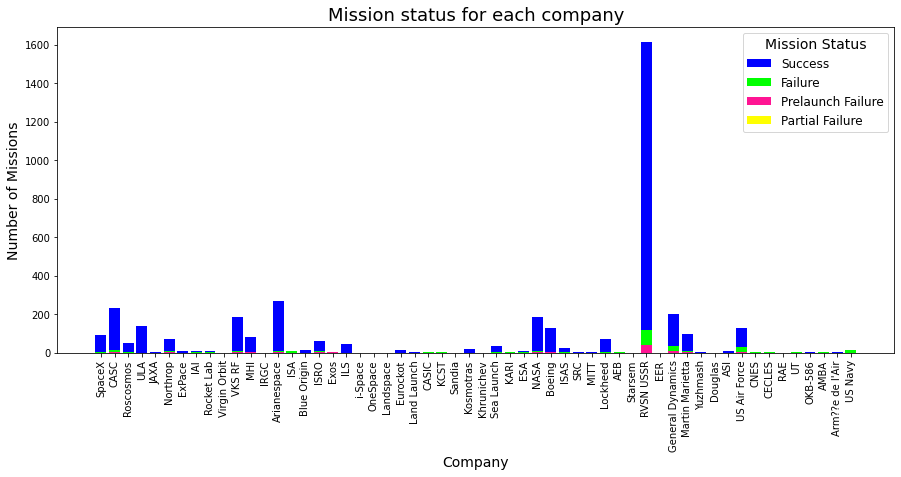

In [161]:
plt.figure(figsize=(15,6))
plt.bar(x=df['company_name'].unique(), height=new1, color='blue')
plt.bar(x=df['company_name'].unique(), height=new2, color='lime')
plt.bar(x=df['company_name'].unique(), height=new4, color='deeppink')
plt.bar(x=df['company_name'].unique(), height=new3, color='yellow')
plt.xticks(rotation=90)
plt.xlabel('Company',fontsize=14)
plt.ylabel('Number of Missions',fontsize=14)
plt.legend(['Success', 'Failure', 'Prelaunch Failure', 'Partial Failure'],fontsize=12, title='Mission Status', title_fontsize=14)
plt.title('Mission status for each company',fontsize=18)
plt.show()

We find the top 5 companies with the highest number of successful, failed, prelaunch failed and partially failed missions.

In [87]:
df_success=pd.DataFrame({'company':df['company_name'].unique(), 'successful_missions':new1})
df_success_sorted=df_success.sort_values(by='successful_missions',ascending=False).head(5)

df_failed=pd.DataFrame({'company':df['company_name'].unique(), 'failed_missions':new2})
df_failed_sorted=df_failed.sort_values(by='failed_missions',ascending=False).head(5)

df_prelaunch_failed =pd.DataFrame({'company':df['company_name'].unique(), 'prelaunch_failed _missions':new3})
df_prelaunch_failed_sorted=df_prelaunch_failed.sort_values(by='prelaunch_failed _missions',ascending=False).head(5)

df_partially_failed =pd.DataFrame({'company':df['company_name'].unique(), 'partially_failed _missions':new4})
df_partially_failed_sorted=df_partially_failed.sort_values(by='partially_failed _missions',ascending=False).head(5)

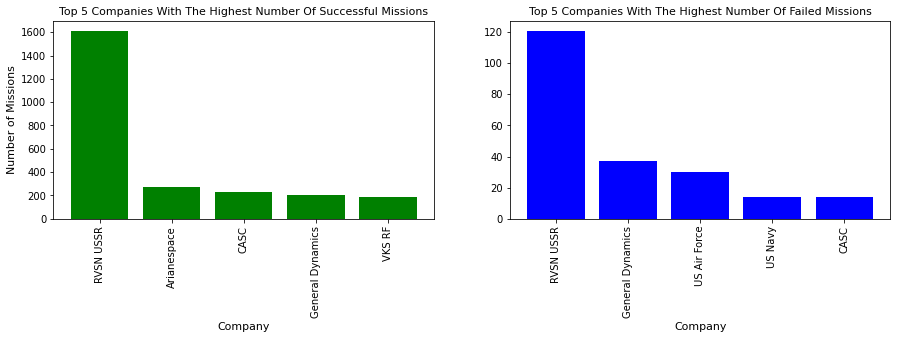

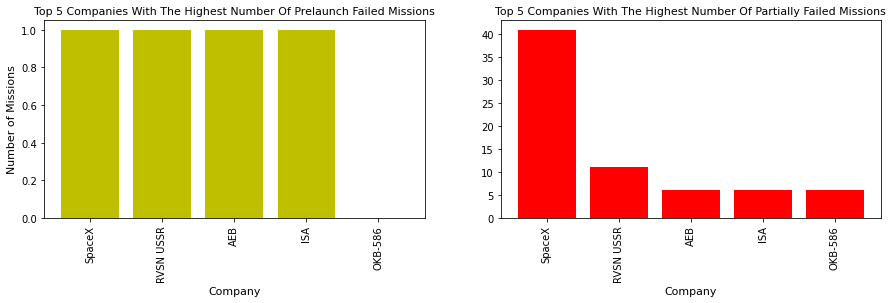

In [116]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.bar(x=df_success_sorted['company'], height=df_success_sorted['successful_missions'],color='g')
plt.xticks(rotation=90)
plt.xlabel('Company',fontsize=11)
plt.ylabel('Number of Missions',fontsize=11)
plt.title('Top 5 Companies With The Highest Number Of Successful Missions',fontsize=11)

plt.subplot(2,2,2)
plt.bar(x=df_failed_sorted['company'], height=df_failed_sorted['failed_missions'],color='b')
plt.xticks(rotation=90)
plt.xlabel('Company',fontsize=11)
plt.title('Top 5 Companies With The Highest Number Of Failed Missions',fontsize=11)

plt.figure(figsize=(15,8))
plt.subplot(2,2,3)
plt.bar(x=df_prelaunch_failed_sorted['company'], height=df_prelaunch_failed_sorted['prelaunch_failed _missions'],color='y')
plt.xticks(rotation=90)
plt.xlabel('Company',fontsize=11)
plt.ylabel('Number of Missions',fontsize=11)
plt.title('Top 5 Companies With The Highest Number Of Prelaunch Failed Missions',fontsize=11)

plt.subplot(2,2,4)
plt.bar(x=df_prelaunch_failed_sorted['company'], height=df_partially_failed_sorted['partially_failed _missions'],color='r')
plt.xticks(rotation=90)
plt.xlabel('Company',fontsize=11)
plt.title('Top 5 Companies With The Highest Number Of Partially Failed Missions',fontsize=11)
plt.show()

Let's find the total number of active and retired rockets.

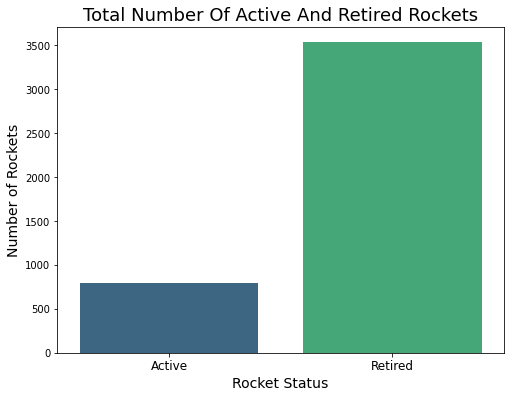

In [129]:
plt.figure(figsize=(8,6))
sns.countplot(x='status_rocket', data=df, palette='viridis')
plt.xticks([0,1], ['Active', 'Retired'], fontsize=12)
plt.xlabel('Rocket Status', fontsize=14)
plt.ylabel('Number of Rockets', fontsize=14)
plt.title('Total Number Of Active And Retired Rockets', fontsize=18)
plt.show()

We analyze the number of active and retired rockets in each company.

In [130]:
new5=[]
for x in df['company_name'].unique():
    df1=df[df['company_name']==x]
    new5.append(df1[df1['status_rocket']=='StatusActive']['status_rocket'].count())

new6=[]
for x in df['company_name'].unique():
    df1=df[df['company_name']==x]
    new6.append(df1[df1['status_rocket']=='StatusRetired']['status_rocket'].count())

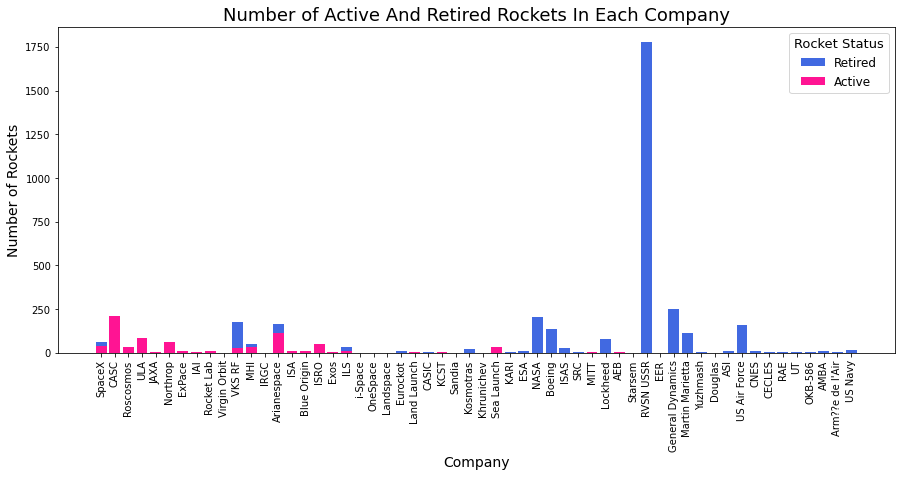

In [177]:
plt.figure(figsize=(15,6))
plt.bar(x=df['company_name'].unique(), height=new6,color='royalblue')
plt.bar(x=df['company_name'].unique(), height=new5,color='deeppink')
plt.xlabel('Company', fontsize=14)
plt.ylabel('Number of Rockets', fontsize=14)
plt.xticks(rotation=90)
plt.legend(['Retired', 'Active'], title='Rocket Status', fontsize=12, title_fontsize=13)
plt.title('Number of Active And Retired Rockets In Each Company', fontsize=18)
plt.show()

We find the status of missions in each year.

In [143]:
new7=[]
for x in df['year'].unique():
    df2=df[df['year']==x]
    new7.append(df2[df2['status_mission']=='Success']['status_mission'].count())

new8=[]
for x in df['year'].unique():
    df2=df[df['year']==x]
    new8.append(df2[df2['status_mission']=='Failure']['status_mission'].count())
    
new9=[]
for x in df['year'].unique():
    df2=df[df['year']==x]
    new9.append(df2[df2['status_mission']=='Prelaunch Failure']['status_mission'].count())
    
new10=[]
for x in df['year'].unique():
    df2=df[df['year']==x]
    new10.append(df2[df2['status_mission']=='Partial Failure']['status_mission'].count())    

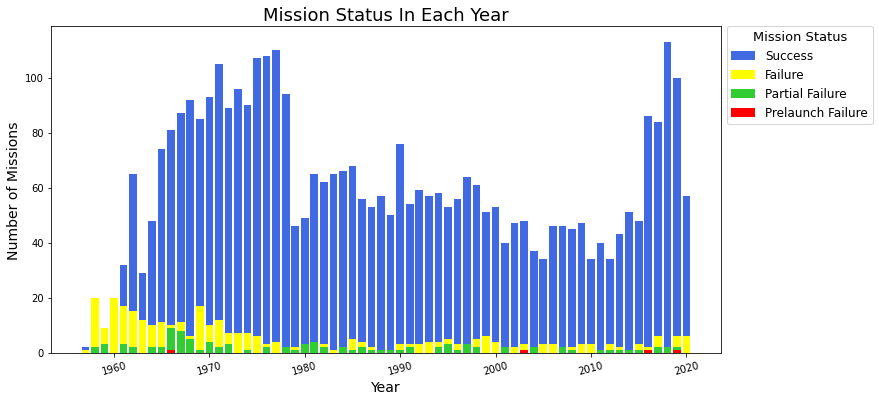

In [257]:
plt.figure(figsize=(12,6))
plt.bar(x=df['year'].unique(), height=new7,color='royalblue')
plt.bar(x=df['year'].unique(), height=new8,color='yellow')
plt.bar(x=df['year'].unique(), height=new10,color='limegreen')
plt.bar(x=df['year'].unique(), height=new9,color='red')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Missions', fontsize=14)
plt.xticks(rotation=15)
plt.legend(['Success', 'Failure','Partial Failure', 'Prelaunch Failure'], fontsize=12, title='Mission Status', title_fontsize=13, bbox_to_anchor=(1,1.02))
plt.title('Mission Status In Each Year', fontsize=18)
plt.show()

Let's find the top 15 locations with the highest number of missions.

In [167]:
df_loc=df.groupby(by='location').count().sort_values(by='company_name', ascending=False).head(15)

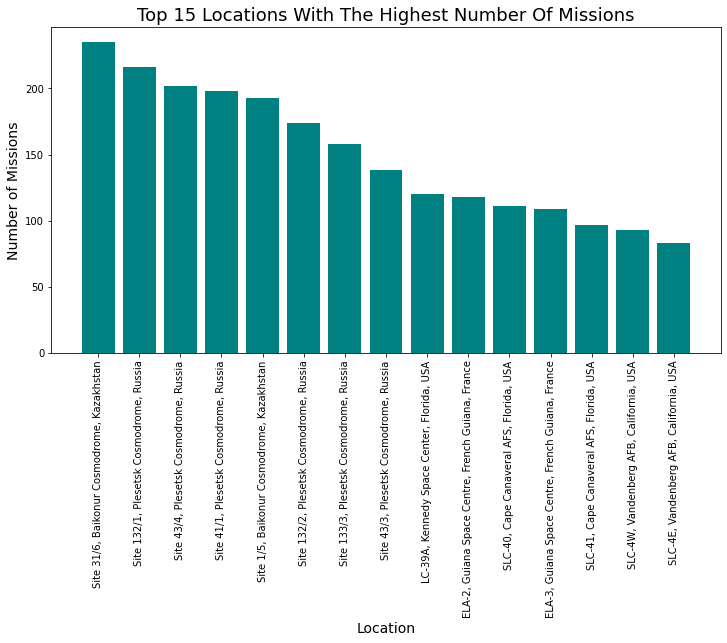

In [245]:
plt.figure(figsize=(12,6))
plt.bar(x=list(df_loc.index), height=df_loc['company_name'],color='teal')
plt.xlabel('Location', fontsize=14)
plt.ylabel('Number of Missions', fontsize=14)
plt.xticks(rotation=90)
plt.title('Top 15 Locations With The Highest Number Of Missions', fontsize=18)
plt.show()

Let's find the number of missions carried out in each country.

In [19]:
df_country=df.groupby('country').count().sort_values(by='company_name',ascending=False)

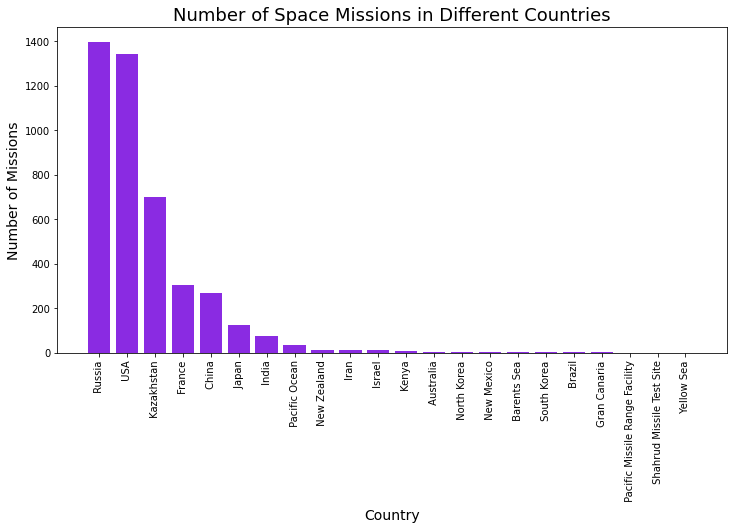

In [20]:
plt.figure(figsize=(12,6))
plt.bar(x=list(df_country.index), height=df_country['company_name'],color='blueviolet')
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Missions', fontsize=14)
plt.xticks(rotation=90)
plt.title('Number of Space Missions in Different Countries', fontsize=18)
plt.show()

Russia carried out the highest number of missions and  USA was in the second place. 

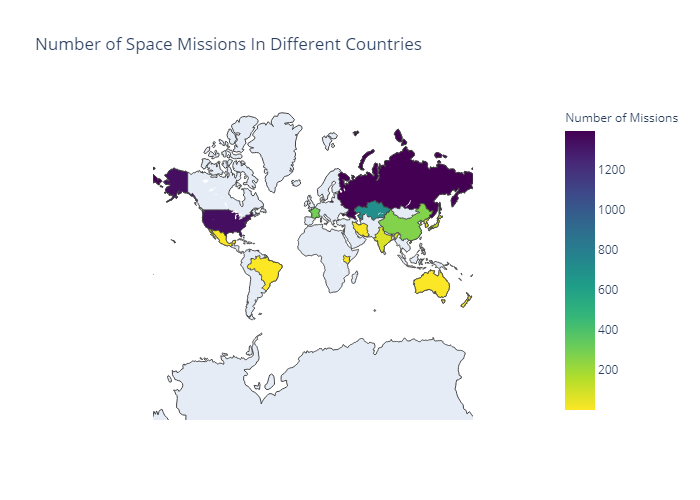

In [30]:
data=dict(type='choropleth', locations=list(df_country.index), locationmode='country names', colorscale='viridis', reversescale=True, text=list(df_country.index),z=df_country['company_name'], colorbar={'title':'Number of Missions'})
layout=dict(title='Number of Space Missions In Different Countries', geo=dict(showframe=False, projection={'type': 'mercator'}))
choromap=go.Figure(data=[data], layout=layout)
Image(pio.to_image(choromap,format='png'))

We visualize the percentage distribution of top 5 countries involved in space missions.

In [213]:
df_country_10=df.groupby('country').count().sort_values(by='company_name',ascending=False).head(5)

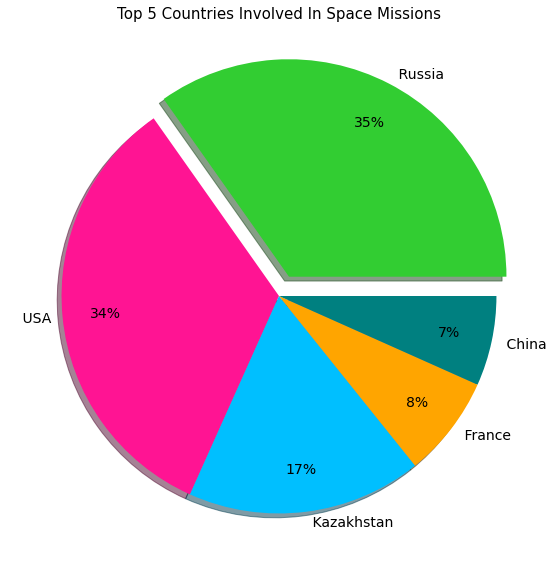

In [229]:
plt.figure(figsize=(10,10))
plt.pie(x=df_country_10['company_name'],labels=list(df_country_10.index), pctdistance=0.8, labeldistance=1.05,autopct='%1.0f%%',
  explode=(0.1,0,0,0,0),shadow=True,
    startangle=0,
  colors=['limegreen', 'deeppink', 'deepskyblue', 'orange','teal'],
    textprops={'fontsize':14})
plt.title('Top 5 Countries Involved In Space Missions', fontsize=15)
plt.show()

We analyze the status of missions in each country.

In [247]:
new11=[]
for x in df['country'].unique():
    df_count=df[df['country']==x]
    new11.append(df_count[df_count['status_mission']=='Success']['status_mission'].count())

new12=[]
for x in df['country'].unique():
    df_count=df[df['country']==x]
    new12.append(df_count[df_count['status_mission']=='Failure']['status_mission'].count())
    
new13=[]
for x in df['country'].unique():
    df_count=df[df['country']==x]
    new13.append(df_count[df_count['status_mission']=='Prelaunch Failure']['status_mission'].count())
    
new14=[]
for x in df['country'].unique():
    df_count=df[df['country']==x]
    new14.append(df_count[df_count['status_mission']=='Partial Failure']['status_mission'].count())

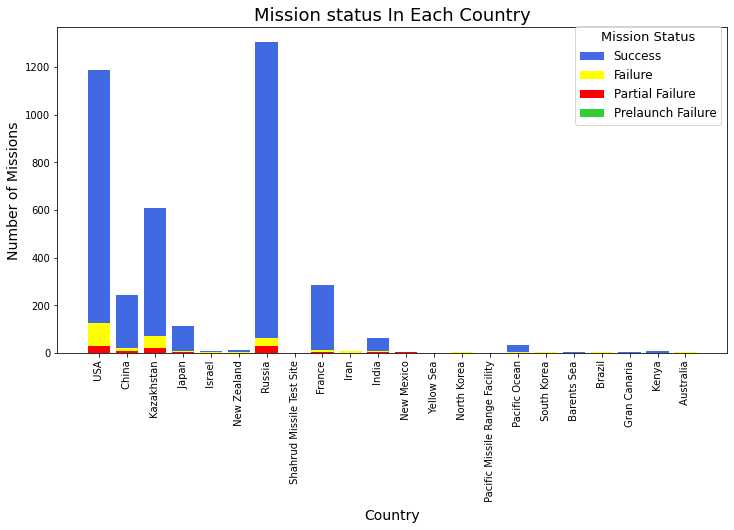

In [263]:
plt.figure(figsize=(12,6))
plt.bar(x=df['country'].unique(), height=new11,color='royalblue')
plt.bar(x=df['country'].unique(), height=new12,color='yellow')
plt.bar(x=df['country'].unique(), height=new14,color='red')
plt.bar(x=df['country'].unique(), height=new13,color='limegreen')
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Missions', fontsize=14)
plt.xticks(rotation=90)
plt.legend(['Success', 'Failure','Partial Failure', 'Prelaunch Failure'], fontsize=12, title='Mission Status', title_fontsize=13, bbox_to_anchor=(1,1.02))
plt.title('Mission status In Each Country', fontsize=18)
plt.show()

Here we explore the number of missions carried out in US states.

In [22]:
df_usa=df[df['country']== ' USA']
df_usa['state']=df_usa['location'].apply(lambda x: x.split(',')[-2])
df_usa.head(2)

C:\Users\Soha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,company_name,location,status_rocket,status_mission,year,country,state
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",StatusActive,Success,2020,USA,Florida
2,SpaceX,"Pad A, Boca Chica, Texas, USA",StatusActive,Success,2020,USA,Texas


In [23]:
df_usa_sorted=df_usa.groupby('state').count().sort_values(by='company_name',ascending=False)

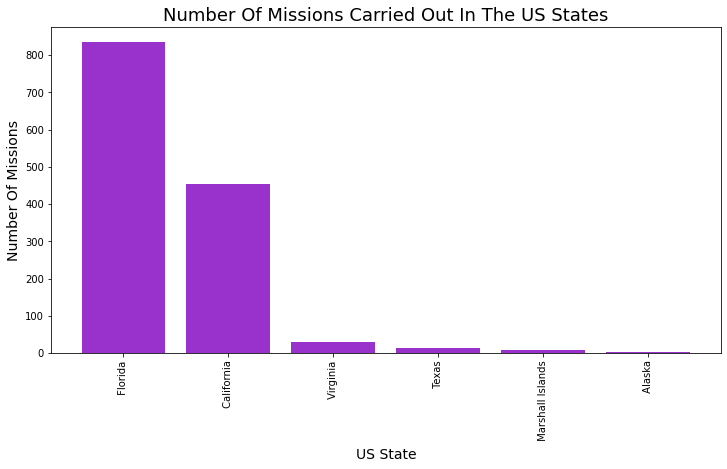

In [27]:
plt.figure(figsize=(12,6))
plt.bar(x=list(df_usa_sorted.index), height=df_usa_sorted['company_name'], color='darkorchid')
plt.xlabel('US State', fontsize=14)
plt.ylabel('Number Of Missions', fontsize=14)
plt.xticks(rotation=90)
plt.title('Number Of Missions Carried Out In The US States', fontsize=18)
plt.show()

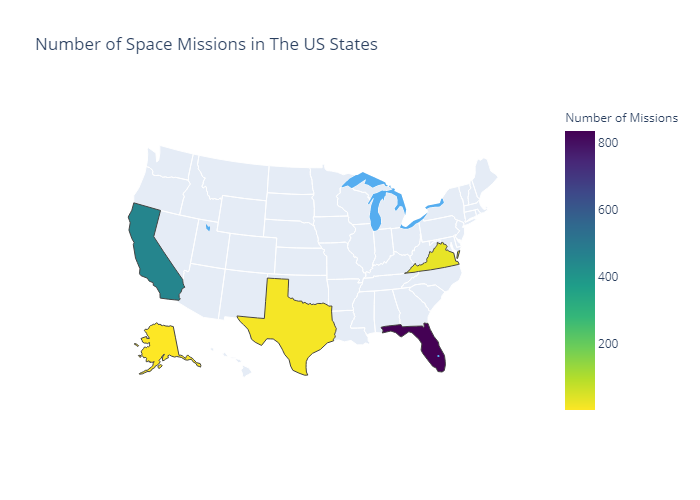

In [29]:
data=dict(type='choropleth', locations=['FL','CA','VA','TX','MH','AK'], locationmode='USA-states', colorscale='viridis', reversescale=True, text=['FL','CA','VA','TX','MH','AK'],z=df_usa_sorted['company_name'], colorbar={'title':'Number of Missions'})
layout=dict(title='Number of Space Missions in The US States', geo=dict(scope='usa', showlakes=True, lakecolor='rgb(85,173,240)'))
choromap=go.Figure(data=[data], layout=layout)
Image(pio.to_image(choromap,format='png'))

Let's find the number of missions conducted in each country in each year.

In [276]:
m=[]
for x in df['country'].unique():
    n=[]
    df_c=df[df['country']== x]
    for y in df['year'].unique():
        df_y=df_c[df_c['year']==y]
        n.append(df_y.count()['year'])
    m.append(n)

In [277]:
pivot=pd.DataFrame(data=m, columns=df['year'].unique(), index=df['country'].unique())

In [81]:
pivot.head(2)

,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,...,1966,1965,1964,1963,1962,1961,1960,1959,1958,1957
USA,21,24,33,30,27,21,23,19,13,18,...,47,33,24,17,60,43,30,16,23,1
China,22,33,39,18,22,2,1,2,1,2,...,0,0,0,0,0,0,0,0,0,0


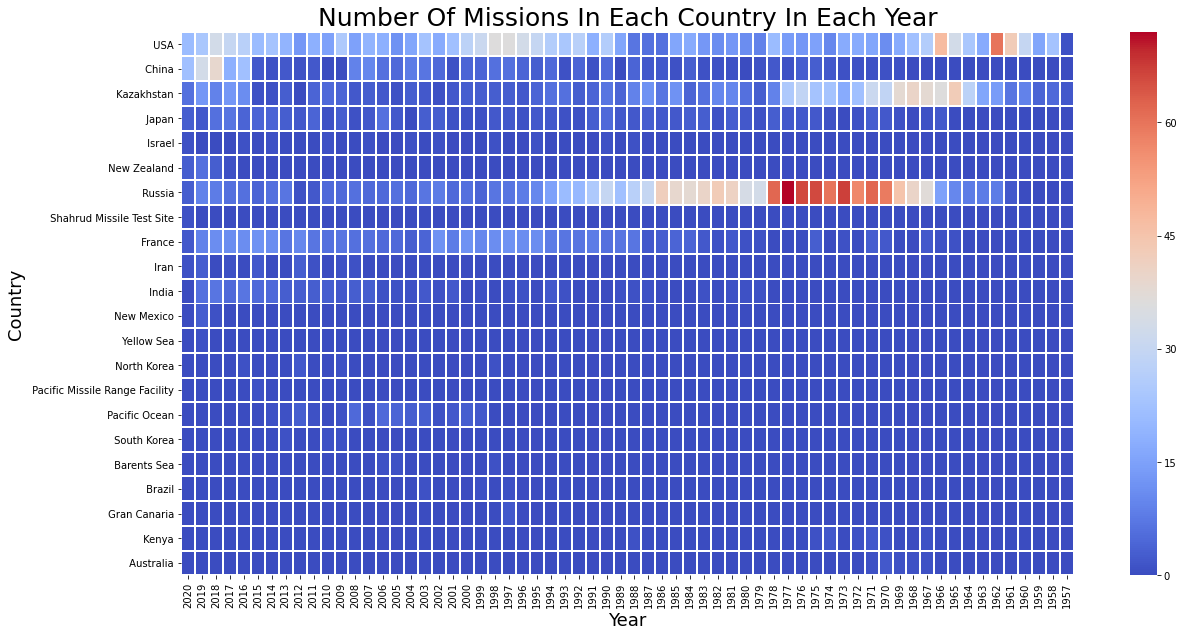

In [305]:
plt.figure(figsize=(20,10))
sns.heatmap(pivot,cmap='coolwarm',linecolor='white', linewidth= 1)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Country', fontsize=18)
plt.title('Number Of Missions In Each Country In Each Year', fontsize=25)
plt.show()

## 6. Prediction of the Status of Missions

### 6.1. Label Encoding

**Company**

In [307]:
le1=LabelEncoder()
le1.fit(df['company_name'])
df['company_name']=le1.transform(df['company_name'])

**Status Rocket**

In [308]:
le2=LabelEncoder()
le2.fit(df['status_rocket'])
df['status_rocket']=le2.transform(df['status_rocket'])

**Country**

In [309]:
le3=LabelEncoder()
le3.fit(df['country'])
df['country']=le3.transform(df['country'])

In [310]:
df.head(2)

,company_name,location,status_rocket,status_mission,year,country
0,46,"LC-39A, Kennedy Space Center, Florida, USA",0,Success,2020,20
1,7,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",0,Success,2020,3


### 6.2. Splitting the Data

In [372]:
X=df[['company_name', 'status_rocket', 'year', 'country']]
y= df['status_mission']

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### 6.3. Logistic Regression

In [374]:
lr=LogisticRegression()
lr.fit(X,y)
predictions_lr=lr.predict(X_test)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



In [375]:
print(confusion_matrix(y_test,predictions_lr))
print('\n')
print(classification_report(y_test,predictions_lr))

[[  0   0  57]
 [  0   0  18]
 [  0   0 790]]


                 precision    recall  f1-score   support

        Failure       0.00      0.00      0.00        57
Partial Failure       0.00      0.00      0.00        18
        Success       0.91      1.00      0.95       790

       accuracy                           0.91       865
      macro avg       0.30      0.33      0.32       865
   weighted avg       0.83      0.91      0.87       865



C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



This model is pretty bad because of zero values

### 6.4. Decision Tree Classifier

In [376]:
dtc=DecisionTreeClassifier()
dtc.fit(X_train,y_train)
predictions_dtc=dtc.predict(X_test)

In [377]:
print(confusion_matrix(y_test,predictions_dtc))
print('\n')
print(classification_report(y_test,predictions_dtc))

[[ 13   2  42]
 [  2   0  16]
 [ 27   9 754]]


                 precision    recall  f1-score   support

        Failure       0.31      0.23      0.26        57
Partial Failure       0.00      0.00      0.00        18
        Success       0.93      0.95      0.94       790

       accuracy                           0.89       865
      macro avg       0.41      0.39      0.40       865
   weighted avg       0.87      0.89      0.88       865



### 6.5. Random Forest Classifier

In [378]:
rfc=RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
predictions_rfc=rfc.predict(X_test)

In [379]:
print(confusion_matrix(y_test,predictions_rfc))
print('\n')
print(classification_report(y_test,predictions_rfc))

[[ 12   2  43]
 [  1   0  17]
 [ 18   1 771]]


                 precision    recall  f1-score   support

        Failure       0.39      0.21      0.27        57
Partial Failure       0.00      0.00      0.00        18
        Success       0.93      0.98      0.95       790

       accuracy                           0.91       865
      macro avg       0.44      0.40      0.41       865
   weighted avg       0.87      0.91      0.89       865



### 6.6. Support Vector Classifier

In [380]:
svc=SVC()
svc.fit(X_train,y_train)
predictions_svc=svc.predict(X_test)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [381]:
print(confusion_matrix(y_test,predictions_svc))
print('\n')
print(classification_report(y_test,predictions_svc))

[[  5   1  51]
 [  0   0  18]
 [  2   0 788]]


                 precision    recall  f1-score   support

        Failure       0.71      0.09      0.16        57
Partial Failure       0.00      0.00      0.00        18
        Success       0.92      1.00      0.96       790

       accuracy                           0.92       865
      macro avg       0.54      0.36      0.37       865
   weighted avg       0.89      0.92      0.88       865



To improve the results obtained by SVC, we use GridSearchCV and define C and gamma parameters.

In [382]:
param_grid={'C':[0.1,1,10,100,1000], 'gamma':[1,0.1,0.01,0.001,0.0001],'kernel':['rbf']}

In [383]:
gs=GridSearchCV(SVC(),param_grid, verbose=3)
gs.fit(X_train,y_train)
predictions_gs=gs.predict(X_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.893, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.893, total=   0.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.893, total=   0.6s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.893, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.893, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.893, total=   0.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.893, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.893, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.893, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.878, total=   0.6s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.887, total=   0.7s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.885, total=   0.7s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.871, total=   6.6s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.879, total=  15.4s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.873, total=   9.6s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.886, total=  11.7s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  3.6min finished


In [384]:
print(confusion_matrix(y_test,predictions_gs))
print('\n')
print(classification_report(y_test,predictions_gs))

[[  3   0  54]
 [  0   0  18]
 [  4   0 786]]


                 precision    recall  f1-score   support

        Failure       0.43      0.05      0.09        57
Partial Failure       0.00      0.00      0.00        18
        Success       0.92      0.99      0.95       790

       accuracy                           0.91       865
      macro avg       0.45      0.35      0.35       865
   weighted avg       0.86      0.91      0.88       865



C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### 6.7. XGBoost Classifier

In [385]:
xgbc=xgb.XGBClassifier(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [386]:
predictions_xgbc=xgbc.predict(X_test)

In [387]:
print(confusion_matrix(y_test,predictions_xgbc))
print('\n')
print(classification_report(y_test,predictions_xgbc))

[[ 10   2  45]
 [  1   0  17]
 [ 16   1 773]]


                 precision    recall  f1-score   support

        Failure       0.37      0.18      0.24        57
Partial Failure       0.00      0.00      0.00        18
        Success       0.93      0.98      0.95       790

       accuracy                           0.91       865
      macro avg       0.43      0.38      0.40       865
   weighted avg       0.87      0.91      0.88       865



In [388]:
print('Accuracy Score, Logistic Regression: ', round(accuracy_score(y_test,predictions_lr),ndigits=4))
print('Accuracy Score, Decision Tree Classifier: ', round(accuracy_score(y_test,predictions_dtc),ndigits=4))
print('Accuracy Score, Random Forest Classifier: ', round(accuracy_score(y_test,predictions_rfc),ndigits=4))
print('Accuracy Score, Support Vector Classifier: ', round(accuracy_score(y_test,predictions_gs),ndigits=4))
print('Accuracy Score, XGBoost Classifier: ', round(accuracy_score(y_test,predictions_xgbc), ndigits=4))

Accuracy Score, Logistic Regression:  0.9133
Accuracy Score, Decision Tree Classifier:  0.8867
Accuracy Score, Random Forest Classifier:  0.9052
Accuracy Score, Support Vector Classifier:  0.9121
Accuracy Score, XGBoost Classifier:  0.9052


So we conclude that Support Vector Classifier for which the hyper-parameters were tuned by Grid Search has an accuracy of 91.21%, and so it is the best model for predicting the status of the missions.

## 7. Conclusion

-  We performed Data Cleaning and Feature Engineering to convert the dataset to an acceptable format.

-  We performed Exploratory Data Analysis and visualized the number of missions versus different features.

-  Support Vector Classifier which was optimized by Grid Search with the accuracy of 91.21% was the best model for predicting  the status of the missions.